In [5]:
import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns
import itertools

## Importing data

The `perf_report/` directory contains `sandmark` runs on three compiler branches.
The `trunk` branch will checkout OCaml at the branching point on which the `ctf` branch is based.

```shell
https://github.com/Engil/ocaml/tarball/ba90da42ac4521fa727c2edc55b2085c9aa29712
```

The `ctf` branch is the main implementation for the tracing system, and the `ctf_off` branch is the same branch, albeit with tracing disabled in all cases, but still compiled with support in.

We now load these traces:


In [6]:
data_frames = []

for file in glob.glob("perf_report/*.bench"):
    with open(file) as bench_file:
        cur_record = bench_file.readline()
        while cur_record:
            data = json.loads(cur_record)
            df = pdjson.json_normalize(data)
            df['variant'] = file.replace(".bench","").replace("perf_report/", "")
            data_frames.append(df)
            cur_record = bench_file.readline()

df = pd.concat(data_frames)

## Comparing the difference between two branches

We define here a few functions we'll use to get relevant data on performance regressions in our branches.

In [7]:

def compute_differences(variants, using='time_secs'):
    variants_filter = df['variant'].isin(variants)
    filtered = df[variants_filter]
    top = filtered.groupby(['name','variant']).aggregate({'time_secs': 'sum'}).groupby('name').pct_change()
    top = top.sort_values(by="time_secs", ascending=False)
    return top

The return data can then be sorted.

This implementation is a bit hacky but the way to understand it is:
`time_secs` now contains the difference (as with `pandas`'s `pct_change`) between the sum of the running time for the variant `b` compared to the running time to the previous variant `a` in the `variants` argument as passed to the `compute_differences` function.

As such, the first variant's `time_secs` values in the list will be `NaN` because there was no previous branch.
However sorting these with `sort_values` places these at the very bottom of the list, we could truncate is as well.

Comparing the `ctf` and `trunk` branch:

In [8]:
data = compute_differences(["4.10.0+trunk","4.10.0+ctf"])
data = data[data["time_secs"].notna()] # filtering out NaN time_secs, from the base variant

data.quantile([.1, .25, .50, .75, .95, .99])

,time_secs
0.10,-0.044838
0.25,-0.017431
0.50,-0.002485
0.75,0.001019
0.95,0.015940
0.99,0.064352


Above we check the percentiles for the percentage change between the `trunk` and `ctf` branch.
We can see that these values are for the `trunk` branch compared to the `ctf` branch.

In [9]:
data.head(1)

,,time_secs
name,variant,
array_bench.array_forall_1000_100000,4.10.0+trunk,0.164999


In this case, the `trunk` branch executed 16% slower than the `ctf` branch.
As such, 10th percentile shows that `trunk` is 7% faster, 25th is 3% faster and so on. 99th percentile is 12% slower than the `ctf` branch.

Let's investigate the worst offenders, as `trunk` should not be expected to be slower than `ctf`.

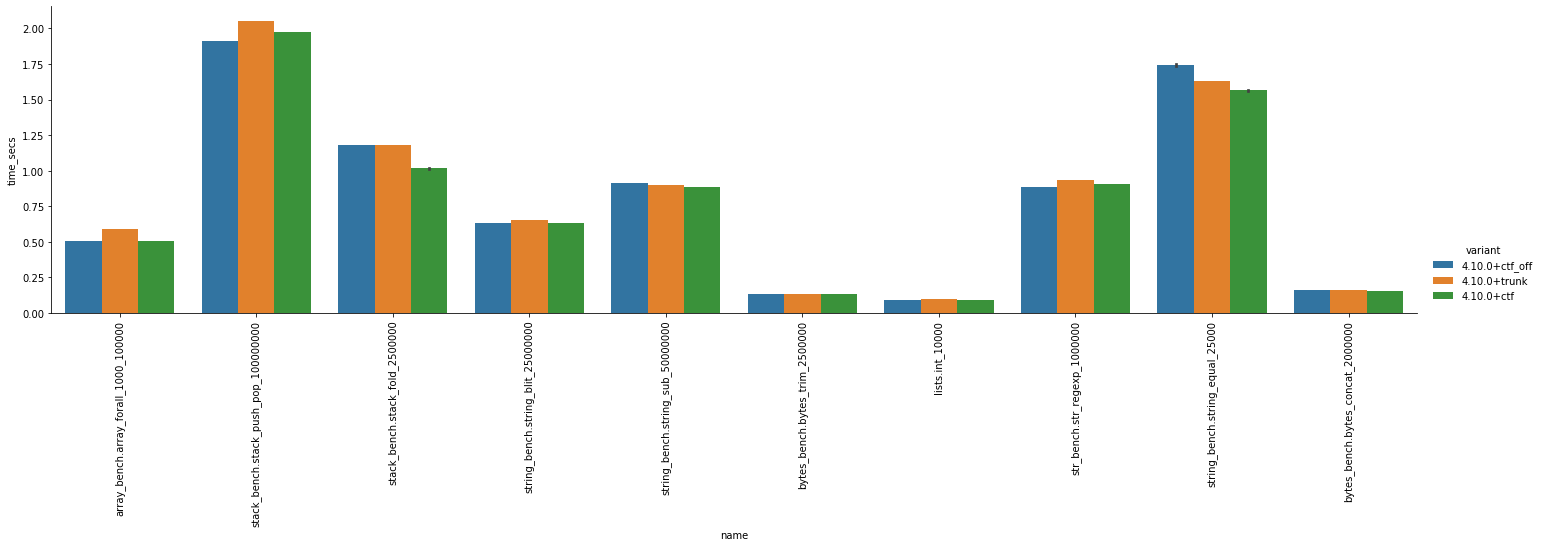

In [10]:
top = data.head(10)
benchmarks = [item for (item, _) in top.index]
res = df.loc[df['name'].isin(benchmarks)]
g = sns.catplot (x='name', y='time_secs', hue='variant', data = res, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)


These results are weird because `trunk` shouldn't actually be any slower than the `ctf` branch.
We may give a try at ruling out proeminent noise from these results by checking how these binaries behave under `perf`.
We then have a proper basis to handcheck peculiar results.

`array_bench.array_forall_1000_100000` seems like a top contender for this check:

We run the same binary through `perf stat -d`:

```shell
# All of this was run on bench2 with the same binaries used in the sandmark runs above
# Everything was pinned to CPU 3, and with --addr-no-randomize

# ctf branch

$ env OCAML_EVENTLOG_ENABLED=1 perf stat -d ./array_bench.exe forall 1000 100000

 Performance counter stats for './array_bench.exe forall 1000 100000':

          0.816574      task-clock (msec)         #    0.778 CPUs utilized          
                 0      context-switches          #    0.000 K/sec                  
                 0      cpu-migrations            #    0.000 K/sec                  
               107      page-faults               #    0.131 M/sec                  
           1947603      cycles                    #    2.385 GHz                    
           1335864      stalled-cycles-frontend   #   68.59% frontend cycles idle   
           1293987      instructions              #    0.66  insn per cycle         
                                                  #    1.03  stalled cycles per insn
            244037      branches                  #  298.855 M/sec                  
             11847      branch-misses             #    4.85% of all branches        
            367375      L1-dcache-loads           #  449.898 M/sec                  
             28742      L1-dcache-load-misses     #    7.82% of all L1-dcache hits  
             12192      LLC-loads                 #   14.931 M/sec                  
              3129      LLC-load-misses           #   25.66% of all LL-cache hits   

       0.001049439 seconds time elapsed

# trunk branch

$ perf stat -d ./array_bench.exe forall 1000 100000

 Performance counter stats for './array_bench.exe forall 1000 100000':

          0.728248      task-clock (msec)         #    0.755 CPUs utilized          
                 0      context-switches          #    0.000 K/sec                  
                 0      cpu-migrations            #    0.000 K/sec                  
               101      page-faults               #    0.139 M/sec                  
           1735806      cycles                    #    2.384 GHz                    
           1159280      stalled-cycles-frontend   #   66.79% frontend cycles idle   
           1223196      instructions              #    0.70  insn per cycle         
                                                  #    0.95  stalled cycles per insn
            229812      branches                  #  315.568 M/sec                  
             10787      branch-misses             #    4.69% of all branches        
            341664      L1-dcache-loads           #  469.159 M/sec                  
             26895      L1-dcache-load-misses     #    7.87% of all L1-dcache hits  
             10891      LLC-loads                 #   14.955 M/sec                  
              2973      LLC-load-misses           #   27.30% of all LL-cache hits   

       0.000964800 seconds time elapsed

# ctf_off branch

$ perf stat -d ./array_bench.exe forall 1000 100000

 Performance counter stats for './array_bench.exe forall 1000 100000':

          0.736076      task-clock (msec)         #    0.759 CPUs utilized          
                 0      context-switches          #    0.000 K/sec                  
                 0      cpu-migrations            #    0.000 K/sec                  
               102      page-faults               #    0.139 M/sec                  
           1754579      cycles                    #    2.384 GHz                    
           1179469      stalled-cycles-frontend   #   67.22% frontend cycles idle   
           1217763      instructions              #    0.69  insn per cycle         
                                                  #    0.97  stalled cycles per insn
            229479      branches                  #  311.760 M/sec                  
             10745      branch-misses             #    4.68% of all branches        
            344388      L1-dcache-loads           #  467.870 M/sec                  
             27457      L1-dcache-load-misses     #    7.97% of all L1-dcache hits  
             11084      LLC-loads                 #   15.058 M/sec                  
              2989      LLC-load-misses           #   26.97% of all LL-cache hits   

       0.000969969 seconds time elapsed

```

We can get this results reliably over a few runs, so it appears that the sandmark numbers were a matter of noise and that the performance impact should actually be in the range of what is mostly observed in the rest of the bench suite.
The same can be observed with the `ctf_off` branch, `trunk` being overall faster but with a much lesser overhead than with tracing enabled.


We can now try to gather more numbers

In [11]:
data.mean()

time_secs   -0.010317
dtype: float64

The mean difference between `trunk` and `ctf` shows a 1% slowdown on the `ctf` branch with tracing enabled.

In [12]:
data = compute_differences(["4.10.0+trunk","4.10.0+ctf_off"])
data = data[data["time_secs"].notna()]

data.quantile([.1, .25, .50, .75, .95, .99])

,time_secs
0.10,-0.042731
0.25,-0.007626
0.50,-0.000928
0.75,0.004861
0.95,0.065975
0.99,0.123290


In [13]:
data.mean()

time_secs   -0.00131
dtype: float64

Above are the result comparing `ctf_off` branch and `trunk`.
Benchmark results shows very negligible performance hit on the `ctf_off` branch, 75th percentile is still below 0.5% slowdown.

In [15]:
data = compute_differences(["4.10.0+ctf","4.10.0+ctf_off"])
data = data[data["time_secs"].notna()]

data.quantile([.1, .25, .50, .75, .95, .99])

,time_secs
0.10,-0.054165
0.25,-0.018749
0.50,-0.002939
0.75,0.003314
0.95,0.066548
0.99,0.133314


In [16]:
data.mean()

time_secs   -0.007814
dtype: float64

In [17]:
data

,,time_secs
name,variant,
stack_bench.stack_fold_2500000,4.10.0+ctf_off,0.164255
string_bench.string_iter_1000000,4.10.0+ctf_off,0.140581
string_bench.string_index_25000000,4.10.0+ctf_off,0.131610
string_bench.string_equal_25000,4.10.0+ctf_off,0.115606
string_bench.string_contains_25000000,4.10.0+ctf_off,0.114628
...,...,...
bytes_bench.bytes_contains_100000000,4.10.0+ctf_off,-0.102909
bytes_bench.bytes_uppercase_ascii_1000000,4.10.0+ctf_off,-0.105784
map_bench.map_find_1000000,4.10.0+ctf_off,-0.107217


Above the results comparing `ctf` and `ctf_off` branches.